## Agent-based modeling and simulation of transport flows in Amsterdam
### This notebook handles the preprocessing of GVB data to deduce a population that can be used in an agent-based simulation of public transport in Amsterdam.

#### Load all packages

In [22]:
import networkx as nx
import warnings
import datetime
import seaborn as sn
sn.set()
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
warnings.filterwarnings('ignore')

#### Load data for origin and destination per hour

In [2]:
origin = pd.read_csv('../../Data/20190403/Datalab_Reis_Herkomst_Uur_20190403.csv', sep=';')
origin = origin.dropna()
destination = pd.read_csv('../../Data/20190403/Datalab_Reis_Bestemming_Uur_20190402.csv', sep=';')
destination = destination.dropna()

In [3]:
# List of all stations in the sub-network
stations = ['Amsteldijk','Amstelstation','Amstelveenseweg','Beethovenstraat','Bullewijk','Burg.de Vlugtlaan', 
    'Centraal Station','Cornelis Troostplein','Dam','De Boelelaan/VU','De Pijp','Europaplein',
    'Gaasperplas','Gein','Gerrit v.d. Veenstraat','Heemstedestraat','Henk Sneevlietweg','IJsbaanpad', 
    'Isolatorweg','Jan v.Galenstraat','Keizersgracht','Koningsplein','Kraaienneststation','Leidseplein',
    'Maasstraat','Marie Heinekenplein','Minervaplein','Muntplein','Museumplein','Nieuwezijds Kolk',
    'Nieuwmarkt','Noord','Noorderpark','Olympiaplein','Olympiaweg','Olympisch stadion','Overamstel', 
    'Postjesweg','Prinsengracht','Reigersbos','Rijksmuseum','Roelof Hartplein','Rokin','Scheldestraat',
    'Spaklerweg','Spui','Station Bijlmer ArenA','Station Diemen-Zuid','Station Duivendrecht',
    'Station Ganzenhoef','Station Holendrecht','Station Lelylaan','Station RAI','Station Sloterdijk', 
    'Strandvliet','Van Baerlestraat','Van der Madeweg','Venserpolder','Verrijn Stuartweg','Victorieplein', 
    'Vijzelgracht','VU medisch centrum','Waalstraat','Waterlooplein','Weesperplein','Wibautstraat','Station Zuid']

#### Change dates to datetime objects and add weekday column

In [4]:
origin['Datum'] = origin['Datum'].apply(lambda x: datetime.datetime.strptime(x[:-3], '%m/%d/%Y %H:%M:%S'))
origin['Weekdag'] = origin['Datum'].apply(lambda x: x.isoweekday())

destination['Datum'] = destination['Datum'].apply(lambda x: datetime.datetime.strptime(x[:-3], '%m/%d/%Y %H:%M:%S'))
destination['Weekdag'] = destination['Datum'].apply(lambda x: x.isoweekday())

#### Remove data where the Noord/Zuid line did not run yet
The Noord/Zuid line was opened on the 21st of July, so all data before August is not used.

In [5]:
origin = origin[origin['Datum'] >= datetime.datetime(2018, 8, 1)]
destination = destination[destination['Datum'] >= datetime.datetime(2018, 8, 1)]

#### Apply necessary filters for analysis
The first analysis is only applied on one type of day (1 = Mondays) and for the stations that are included in the sub-network.

In [6]:
origin = origin[(origin['VertrekHalteNaam'].isin(stations)) & (origin['Weekdag'] == 1)]
destination = destination[(destination['AankomstHalteNaam'].isin(stations)) & (destination['Weekdag'] == 1)]

#### Group by hour for further analysis

In [80]:
origingrouped = origin[['UurgroepOmschrijving (van vertrek)','VertrekHalteNaam', 'AantalReizen']]
origingrouped = origingrouped.groupby(['UurgroepOmschrijving (van vertrek)', 
                                'VertrekHalteNaam']).aggregate(['min', np.median, np.sum, max])
origingrouped['AantalReizen','mean'] = origingrouped['AantalReizen']['sum'].apply(lambda x: float(x/34))
origingrouped = origingrouped.reset_index()
origingrouped.columns = ['hour', 'stop', 'min', 'median', 'sum', 'max', 'mean']

In [141]:
destinationgrouped = destination[['UurgroepOmschrijving (van aankomst)','AankomstHalteNaam', 'AantalReizen']]
destinationgrouped = destinationgrouped.groupby(['UurgroepOmschrijving (van aankomst)', 
                                'AankomstHalteNaam']).aggregate(['min', np.median, np.sum, max])
destinationgrouped['AantalReizen','mean'] = destinationgrouped['AantalReizen']['sum'].apply(lambda x: float(x/34))
destinationgrouped = destinationgrouped.reset_index()
destinationgrouped.columns = ['hour', 'stop', 'min', 'median', 'sum', 'max', 'mean']

#### Create plot of distribution for a certain hour

In [113]:
def plotgroup(hour, dataframe):
    dataframe = dataframe[dataframe['hour'] == hour]
    total = dataframe['sum'].sum()
    dataframe['percentage'] = dataframe['sum'].apply(lambda x: (x / total) * 100)
    dataframe = (dataframe.sort_values(by = 'percentage', ascending = False)).head(10)
    return dataframe.plot(kind = 'barh', x = 'stop', y = 'percentage', figsize = [10,5])

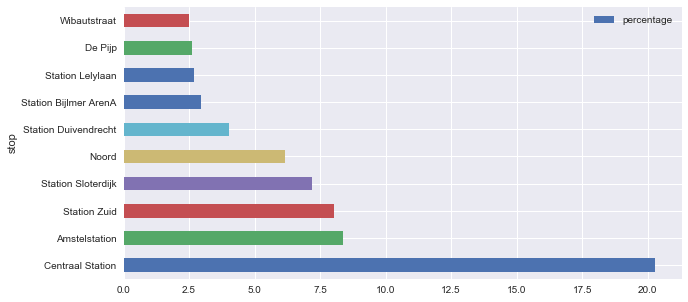

In [114]:
plotgroup('08:00 - 08:59', origingrouped)

#### Save distribution for simulation

In [143]:
origingrouped.to_csv('../Data/origin.csv')
destinationgrouped.to_csv('../Data/destination.csv')